In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/supple6_themes.R"))

library(tidyverse)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)
library(cowplot)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:d

### Read in prepared validation data

In [2]:
dd <- 
readRDS(paste0(TMP_DIR,"validation-measure.Rds")) %>% 
  filter(!is.na(bor), !is.na(os_event), complete, !grepl("HMF", Study_cohort), model == "five_latent") %>% 
  unique() %>% 
  mutate(Study = Study_cohort)

In [3]:
dd$lr_gp <-  cut( dd$pred_lr,  breaks = c(0,.1,.5,    1) , labels = c("Low", "Medium", "High"))
dd$os_gp <-  cut( dd$pred_os,  breaks = c(0,.5,1.5,   20) , labels = c("Low", "Medium", "High"))

In [4]:
dfs <- list(
    "Validation cohorts" = dd %>% filter(Study == "External Studies") %>% unique(),
    "INSPIRE" = dd %>% filter(Study == "INSPIRE") %>% unique(),
    "RAVI" = dd %>% filter(Study == "RAVI") %>% unique(),
    "VHIO" = dd %>% filter(Study == "VHIO") %>% unique()
)

### 0 - Main Distribution Plots
- Main

In [5]:
bar_plot <- function(df, title = "HMF-CPCT", feature1 = "pred_lr", feature2 = "lr_gp") {
    if(title == "HMF-CPCT") { title <- "Pan-Cancer" }
    ggplot( df, aes_string(feature1, fill = feature2)) + 
    geom_histogram(binwidth=.1, color='black', boundary = 0) + 
    labs( x = "Probability of Response", y = "Number of Patients", title = title) + 
    scale_x_continuous(breaks=c(.1,.5), labels = scales::percent_format(scale = 100), limits = c(0,1)) + 
    scale_fill_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3]))
}

In [6]:
dist_plts1 <- list()
for(i in names(dfs)) {
    if (i %in% c("Validation cohorts")){ #, "INSPIRE", "VHIO")){ ### Add DRUP here
        dist_plts1[[i]] <- bar_plot( dfs[[i]], i) + theme_bar_main
    } else {
        dist_plts1[[i]] <- bar_plot( dfs[[i]], i) + theme_bar_tissue
    }
}

### 1 - Distibution plots slim

In [7]:
dist_plotter <- function(df) {
    ggplot(data = df, aes(y=Study, x=ct, fill = lr_gp, label = ct)) + 
    geom_bar(stat="identity", width=.8, position = 'stack', color = "black") + 
    scale_fill_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3])) + 
    geom_text(size = 9, position = position_stack(vjust = .5)) 
}

In [8]:
eva <- dd %>% group_by(Study, lr_gp) %>% summarise( ct = n())
eva$lr_gp <- factor(eva$lr_gp, levels = c("High", "Medium", "Low"))

dist_plts2 <- list()
for (i in c("Validation cohorts")) { 
    plt <- dist_plotter(eva %>% filter(Study == i)) 
    leg <- as_ggplot(get_legend(plt + theme(legend.title=element_blank(), legend.text = element_text(size=18))))
    dist_plts2[[i]] <- plt +  theme_dist
}

`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.


### 2 - Percent Responders within Groups

In [9]:
computer <- function(df) {
    df %>% 
    group_by(lr_gp) %>% 
    summarise(bor = mean(bor), non_bor = 1-mean(bor)) %>% 
    gather("gp", "bor",-lr_gp) %>% 
    mutate(bor2 = paste0(round(bor,2)*100, "%")) %>% 
    filter(gp == "bor")
}
plotter <- function(df){
  ggplot(data = df, aes(x=lr_gp, y=bor, fill = gp, label = bor2, color = lr_gp)) + 
  geom_bar(stat="identity", width=.8, position = 'stack', size = 2.5) + 
  scale_fill_manual(values = c("dark grey", "dark grey")) + 
  labs( y = "% Responders" ) + 
  scale_color_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3])) + 
  scale_y_continuous(breaks=c(0,1), labels = scales::percent_format(scale = 100), limits = c(0,1.3))    
}

#### Compute responders

In [10]:
responders <- list()
for(i in names(dfs)) {
    responders[[i]] = computer(dfs[[i]])
}

#### Store responder plots

In [11]:
responder_plts <- list()
for(i in names(responders)) {
    if( i %in% c("Validation cohorts")) {
        responder_plts[[i]] <- plotter( responders[[i]]) + theme_compute_main + geom_text(size = 8.5, vjust = -.2, color = "black")
    } else {
        responder_plts[[i]] <- plotter( responders[[i]]) + theme_compute_tissue + geom_text(size = 7, vjust = -.2, color = "black")
    } 
}

### 3 - Combining Plots

#### Overall study plots

In [30]:
external <- 
arrangeGrob( 
    dist_plts1$`Validation cohorts` + theme(axis.title.y = element_text(size = 20, angle = 90)), 
    dist_plts2$`Validation cohorts`, 
    responder_plts$`Validation cohorts` + theme(axis.title.y = element_text(size = 20, angle = 90)),
    layout_matrix = layout2)

#### Tissue plots

In [31]:
vhio <- arrangeGrob(dist_plts1[['VHIO']],responder_plts[['VHIO']], layout_matrix = layout)
ravi <- arrangeGrob(dist_plts1[['RAVI']],responder_plts[['RAVI']], layout_matrix = layout)
inspire <- arrangeGrob(dist_plts1[['INSPIRE']],responder_plts[['INSPIRE']], layout_matrix = layout)
other <- arrangeGrob(vhio,ravi,inspire, ncol = 3)

#### All together

In [32]:
together <- arrangeGrob(external, other, leg, layout_matrix = rbind(c(1,1,2,2,2,3),c(1,1,2,2,2,3)))

In [33]:
options(repr.plot.width=18, repr.plot.height=8, resolution = 500)
share <- as_ggplot(together)

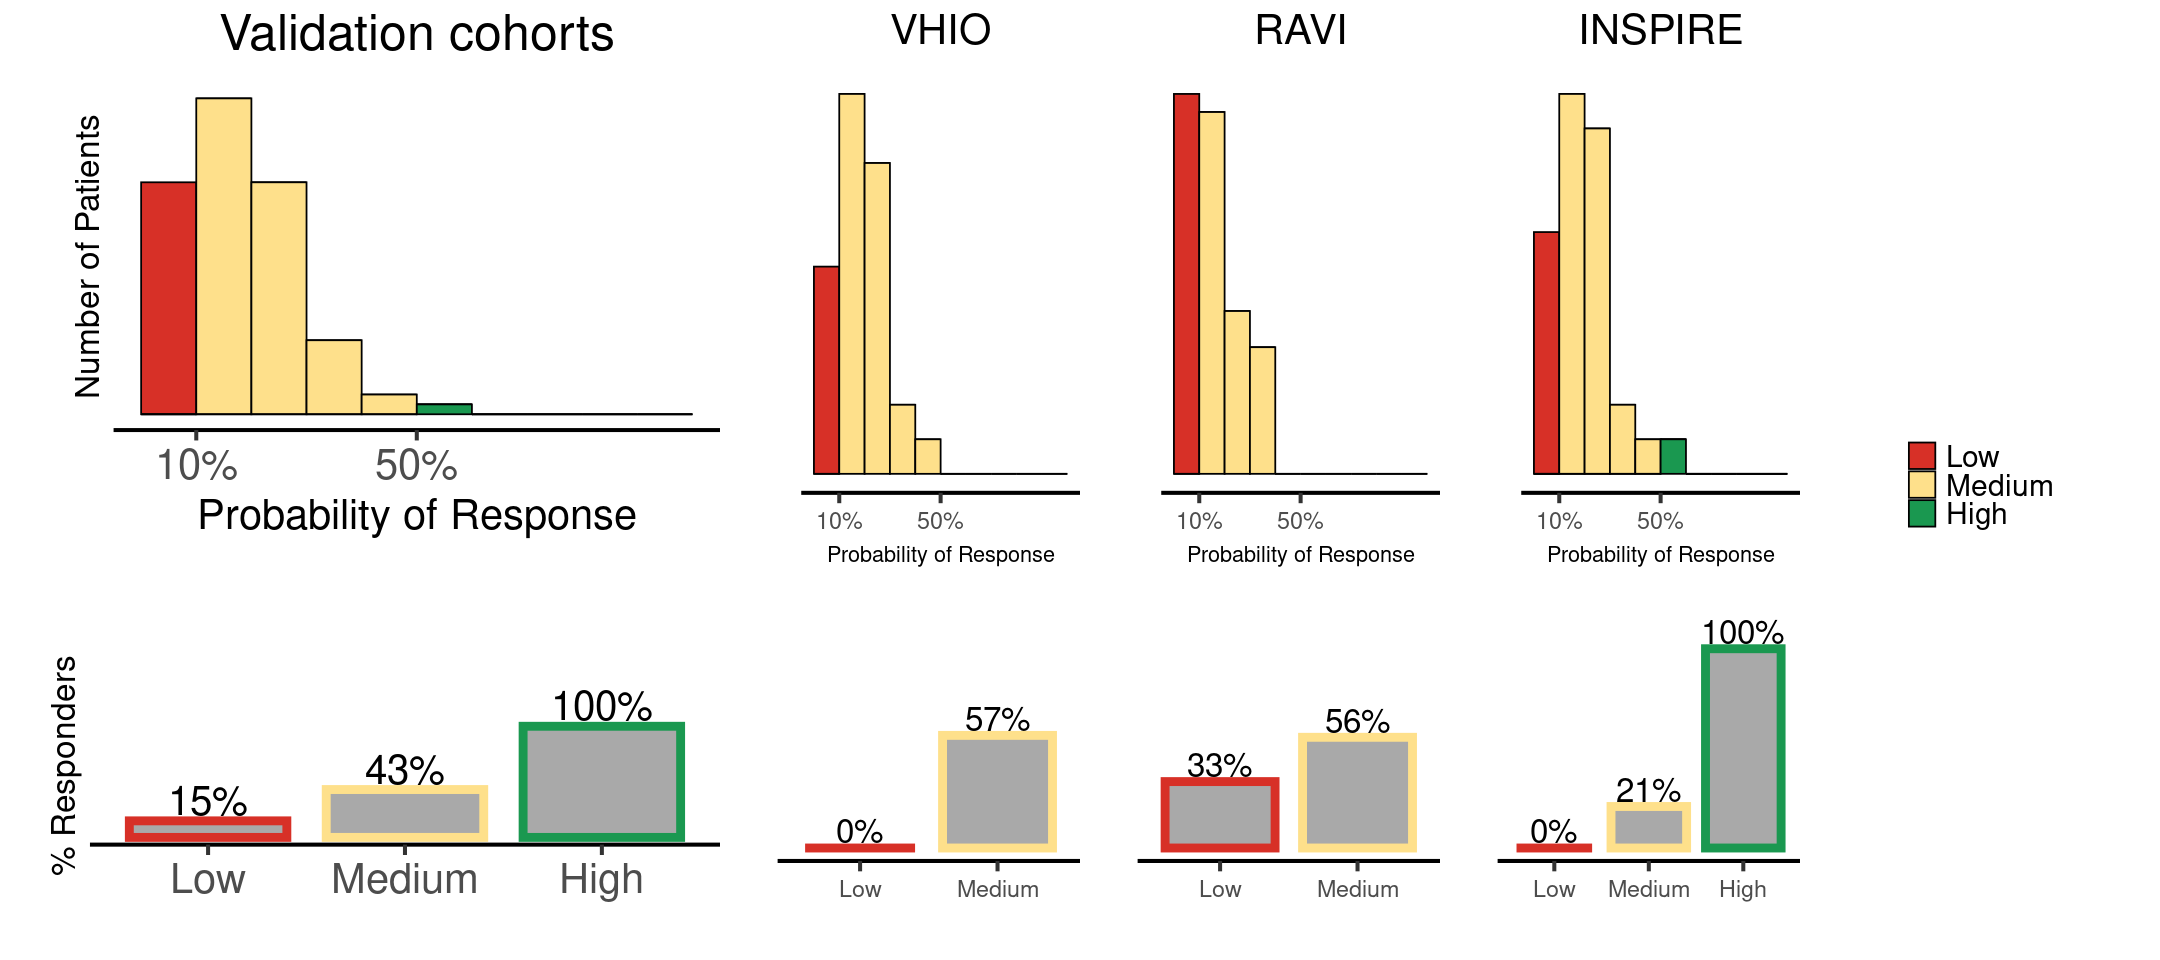

In [34]:
share

In [35]:
saveRDS( share, paste0(FIG_DIR, "6_sm_stratify_external_a.Rds"))